This continues from DB_Reaxys and supplements the database with active fragment/carrier fragment labels

In [1]:
# Allow more than one output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
!conda info


     active environment : impurityproject
    active env location : /home/aa2133/miniconda3/envs/impurityproject
            shell level : 2
       user config file : /home/aa2133/.condarc
 populated config files : 
          conda version : 4.8.5
    conda-build version : not installed
         python version : 3.8.3.final.0
       virtual packages : __glibc=2.23
       base environment : /home/aa2133/miniconda3  (writable)
           channel URLs : https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /home/aa2133/miniconda3/pkgs
                          /home/aa2133/.conda/pkgs
       envs directories : /home/aa2133/miniconda3/envs
                          /home/aa2133/.conda/envs
               platform : linux-64
             user-agent : conda/4.8.5 requests/2.

# Dependencies

In [6]:
import shutil
import itertools
import copy
from MainFunctions import writepickle, openpickle
from collections import Counter, namedtuple
from rdkit.Chem import BRICS  # For fragmenting
from ttictoc import tic, toc
from rxnmapper import RXNMapper  # Importing RXNMapper for unsupervised atom mapping
import os  # Working with the OS
from PIL import Image  # Working with images
from IPython.display import SVG  # For SVG support
from rdkit.Chem.Draw import rdMolDraw2D  # Drawing 2D molecules/reactions
from rdkit.Chem import rdChemReactions  # Reaction processing
from rdkit.Chem import Draw  # For drawing molecules/reactions
from rdkit.Chem import AllChem  # Overall support
from rdkit import Chem  # Importing RDKit
from FindFunctionalGroups import identify_functional_groups as IFG
from helpCompound import hc_smilesDict, hc_molDict
import cairosvg
import json
from chempy import balance_stoichiometry
import io
import matplotlib.pyplot as plt
from IPython.display import display, Image
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import RDConfig
import cirpy
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import PeriodicTable, GetPeriodicTable
from rdkit.Chem import FunctionalGroups
import sys
sys.path.append('/home/aa2133/Impurity-Project')
sys.path.append('/home/aa2133/Impurity-Project/getCandiRxns')
try:
    import pickle5 as pickle  # Only if pickle doesn't work
except Exception:
    import pickle

In [5]:
# %%writefile FunctionsDB.py
# %load ./FunctionsDB.py

import shutil
import itertools
import copy
from MainFunctions import writepickle, openpickle
from collections import Counter, namedtuple

from rdkit import Chem  # Importing RDKit
from rdkit.Chem.Draw import rdMolDraw2D  # Drawing 2D molecules/reactions
from rdkit.Chem import rdChemReactions  # Reaction processing
from rdkit.Chem import Draw  # For drawing molecules/reactions
from rdkit.Chem import AllChem  # Overall support
from FindFunctionalGroups import identify_functional_groups as IFG

import sqlite3
import os
import dask.delayed as delayed
import dask.dataframe as dd
import dask.array as da
import dask.bag as dba
import numpy as np
import pandas as pd

#%% Building basic substance database

def info(molfile):
    mol = Chem.MolFromMolFile(molfile)
    if mol:
        Chem.SanitizeMol(mol)
        mol.UpdatePropertyCache(strict=False)
        smils = Chem.MolToSmiles(mol)
        return mol, smils
    else:
        return molfile


def basic(ID, folder):
    if str.isdecimal(ID):
        molfileaddress = folder+os.sep+ID
        try:
            res = info(molfileaddress)
        except Exception as e:
            error = e
            compaddrs = {'SubstanceID': int(
                ID), 'MolFileAddress': molfileaddress, 'Error': error}
        else:
            if type(res) == tuple:
                smiles = res[1]
                compaddrs = {'SubstanceID': int(
                    ID), 'MolFileAddress': molfileaddress, 'Smiles': smiles}
            else:
                error = 'Valence error'
                compaddrs = {'SubstanceID': int(
                    ID), 'MolFileAddress': molfileaddress, 'Error': error}
    else:
        compaddrs = {}
    return compaddrs


def basicgroup(molfilelist, folder):
    return [basic(ID, folder) for ID in molfilelist]


def substancedblist(folderName, partitions):
    dem = os.listdir(folderName)
    b = db.from_sequence(dem, npartitions=partitions)
    dflist = b.map_partitions(basicgroup, folderName).compute()
    return dflist


#%% Fragment detection
def getCarrierFrags0(smi,expand=1,resFormat='smarts',addHs=True):
    """
    str (smiles), int -> list (str_smiles/smarts) 
    smi: str, smiles of a compound
    size: Level to expand functional group by (eg./ 1 will expand to first degree neighbours, 2 will expand to second degree neighbors etc.)
    resFormat: 'smiles' or 'smarts' 
    addHs: bool, if True H will be consider for generation of substructure, recommend True
            otherwise terminal atoms of a molecule are not differentiated with other atoms
    this function return list of strings of smarts representing carrier frags with miniSize of size
    a carrier frag carries a functional group defined by using Ertl's method
    find out the bonds to cut define a cutter to cut out the target fragments based on bonds to cut
    1) get a list of function groups using IFG
    2) if IFG list empty meaning no functional groups, directly return compound smiles
    3) expand to nearest neighbors based on expand value
    """
    mol = Chem.MolFromSmiles(smi)
    Chem.SanitizeMol(mol)
    mol.UpdatePropertyCache(strict=False)
    if addHs:
        mol = Chem.AddHs(mol)
    # -- get the list of functional groups FG
    # e.g., [IFG(atomIds=(1, 4, 7), atoms='NC=O', type='cNC(C)=O'), IFG(atomIds=(10,), atoms='O', type='cO')]
    IFG_ls = IFG(mol)
    # if IFG_ls is empty, directly return this compounds
    if len(IFG_ls) == 0:
        if resFormat == 'smiles':
            return smi
        elif resFormat == 'smarts':
            return Chem.MolToSmarts(Chem.MolFromSmiles(smi))
    # -- get atomIDs (FGs_atomIDs_expan) and terminalAtomIDs (FGs_terminal_atomIDs) for all frags
    FGs_atomIDs = [_.atomIds for _ in IFG_ls]  # e.g., [(1, 4, 7), ...]
    n_FGs = len(FGs_atomIDs)
    # expan all FGs that < size # e.g., [[1, 4, 7, 8, 9], ...]
    FGs_atomIDs_expan = [None]*n_FGs
    # terminal atoms: atoms on which bonds to cut will be searched
    # [[2, 3, 8], ...] or [[], [], ...], note [2, 3, 8] are terminal of comp not frag
    FGs_terminal_atomIDs = [None]*n_FGs
    for i in range(n_FGs):
#         breakpoint()
        # initialization before search and expand fragments
        FG_atomIDs = list(FGs_atomIDs[i])  # e.g., [1, 4, 7]
        FG_size = len(FG_atomIDs)
        FG_terminal_atomIDs = []  # e.g., [2, 3, 8] or [], HNO3 or C=O -> [] Terminal IDs of fragments
        for atomID in FG_atomIDs:
            neis_IDs = [_.GetIdx() for _ in mol.GetAtomWithIdx(atomID).GetNeighbors()]
            if len(set(neis_IDs) - set(FG_atomIDs)) != 0:
                FG_terminal_atomIDs = FG_terminal_atomIDs + [atomID]
        if len(FG_terminal_atomIDs) == 0:
            # make sure all elements in FGs_atomIDs_expan are lists
            FGs_atomIDs_expan[i] = FG_atomIDs
            FGs_terminal_atomIDs[i] = FG_terminal_atomIDs
            # case 3 still could be [] even if FG_size >= size, though less likely
        else:
            FG_expan_atomIDs = copy.deepcopy(FG_atomIDs)  # e.g., [1, 4, 7]
             # max repeat size times, since repeat size should reach the size
            for rep in range(expand):
                FG_expan_atomIDs_old = copy.deepcopy(FG_expan_atomIDs)
                # not all atoms need be searched for neis, only ones not in FG_expan_atomIDs for each epoch
                for atomID in FG_terminal_atomIDs:
                    neis_IDs = [_.GetIdx() for _ in mol.GetAtomWithIdx(atomID).GetNeighbors()]
                    FG_expan_atomIDs = FG_expan_atomIDs + neis_IDs
                FG_expan_atomIDs = list(set(FG_expan_atomIDs))
                FG_terminal_atomIDs = list(set(FG_expan_atomIDs)-set(FG_expan_atomIDs_old))
                FGs_atomIDs_expan[i] = FG_expan_atomIDs
                FGs_terminal_atomIDs[i] = FG_terminal_atomIDs  # [] case 2
                if len(FG_terminal_atomIDs) == 0:  # cannot expand due to small comp size
                    break  # for expan of next FG
    # it seems not possible that [[2, 3, 8], [], ...], if there one [] then all should be [],
    # either [[]] or [[], [], ...] (i.e., small comp with single or multiple FGs)
    # sum([len(_) for _ in FGs_terminal_atomIDs]) == 0:
#     breakpoint()
    if len(FGs_terminal_atomIDs[0]) == 0:
        if resFormat == 'smiles':
            return smi
        elif resFormat == 'smarts':
            return Chem.MolToSmarts(Chem.MolFromSmiles(smi))
    else:
        FGs_strs = []  # smiles or smarts
        for FG_atomIDs in FGs_atomIDs_expan:
            if resFormat == 'smiles':
                FGs_str = Chem.MolFragmentToSmiles(mol, FG_atomIDs, canonical=True)
                FGs_strs = FGs_strs + [FGs_str]
            elif resFormat == 'smarts':
                FGs_str = Chem.MolFragmentToSmarts(mol, FG_atomIDs, isomericSmarts=False)
                FGs_strs = FGs_strs + [FGs_str]
        return FGs_strs
    
    
def getCarrierFrags(smi, size, resFormat='smarts', addHs=True):
    """
    str (smiles), int -> list (str_smiles/smarts) 
    smi: str, smiles of a compound
    size: size of carrier fragments, number atoms
    resFormat: 'smiles' or 'smarts'
    addHs: bool, if True H will be consider for generation of substructure, recommend True
            otherwise terminal atoms of a molecule are not differentiated with other atoms
    this function return list of strings of smarts representing carrier frags with miniSize of size
    a carrier frag carries a functional group defined by using Ertl's method
    find out the bonds to cut define a cutter to cut out the target fragments based on bonds to cut
    1) get a list of function groups using IFG
    2) if IFG list empty meaning no functional groups, directly return compound smiles
    3) evaluate the size of current fragment,  
       if frag_size >= size, directly return the comp smile
       if frag_size < miniSizeFrag, expand the fragment by searching for neighors, only use terminal atoms to search
       repeat expansion till frag_size >= size
    """
    mol = Chem.MolFromSmiles(smi)
    Chem.SanitizeMol(mol)
    mol.UpdatePropertyCache(strict=False)
    if addHs:
        mol = Chem.AddHs(mol)
    # -- get the list of functional groups FG
    # e.g., [IFG(atomIds=(1, 4, 7), atoms='NC=O', type='cNC(C)=O'), IFG(atomIds=(10,), atoms='O', type='cO')]
    IFG_ls = IFG(mol)
    # if IFG_ls is empty, directly return this compounds
    if len(IFG_ls) == 0:
        if resFormat == 'smiles':
            return smi
        elif resFormat == 'smarts':
            return Chem.MolToSmarts(Chem.MolFromSmiles(smi))
    # -- get atomIDs (FGs_atomIDs_expan) and terminalAtomIDs (FGs_terminal_atomIDs) for all frags
    FGs_atomIDs = [_.atomIds for _ in IFG_ls]  # e.g., [(1, 4, 7), ...]
    n_FGs = len(FGs_atomIDs)
    # expan all FGs that < size # e.g., [[1, 4, 7, 8, 9], ...]
    FGs_atomIDs_expan = [None]*n_FGs
    # terminal atoms: atoms on which bonds to cut will be searched
    # [[2, 3, 8], ...] or [[], [], ...], note [2, 3, 8] are terminal of comp not frag
    FGs_terminal_atomIDs = [None]*n_FGs
    for i in range(n_FGs):
        # initialization before search and expand fragments
        FG_atomIDs = list(FGs_atomIDs[i])  # e.g., [1, 4, 7]
        FG_size = len(FG_atomIDs)
        # find initial terminal atoms
        # terminal atoms: atoms with neis that not belong to FG_atomIDs
        # note terminal atoms here are terminal of fragments not comp
        # C=O has no fragment terminal, but both C and O are comp terminals
        # there are 3 cases that no fragment terminal ie, FG_terminal_atomIDs = [] one case FG_terminal_atomIDs not empty
        # case 1: FG_size < size, and FG_terminal_atomIDs = [], ie., comp too small, no chane to expand e.g., C=O, HCl, HNO3
        # case 2: FG_size < size, and FG_terminal_atomIDs = [2,3,8],
        #         got chane to expand, but after expand still cannot reach size, e.g., OCC=O
        #         eventually FG_terminal_atomIDs = []
        # case 3: FG_size >= size, and FG_terminal_atomIDs = [], cos the whole big comp is a functional group
        # for all above cases the original comp will be return
        # two case FG_terminal_atomIDs is not empty, cutting will performed based on FG_terminal_atomIDs
        # case 4: FG_size >= size, and FG_terminal_atomIDs = [2,3,8], just cut using FG_terminal_atomIDs
        # case 5: FG_size < size, and FG_terminal_atomIDs = [2,3,8], after expand, size reached and FG_terminal_atomIDs changed
        FG_terminal_atomIDs = []  # e.g., [2, 3, 8] or [], HNO3 or C=O -> []
        for atomID in FG_atomIDs:
            neis_IDs = [_.GetIdx() for _ in mol.GetAtomWithIdx(atomID).GetNeighbors()]
            if len(set(neis_IDs) - set(FG_atomIDs)) != 0:
                FG_terminal_atomIDs = FG_terminal_atomIDs + [atomID]
        # perform search / expand fragments
        # [],  case 1 cannot expand, although FG_size < size
        if (FG_size >= size) | (len(FG_terminal_atomIDs) == 0):
            # make sure all elements in FGs_atomIDs_expan are lists
            FGs_atomIDs_expan[i] = FG_atomIDs
            FGs_terminal_atomIDs[i] = FG_terminal_atomIDs
            # case 3 still could be [] even if FG_size >= size, though less likely
        else:
            # init FG to be expand
            FG_expan_atomIDs = copy.deepcopy(FG_atomIDs)  # e.g., [1, 4, 7]
            # max repeat size times, since repeat size should reach the size
            for rep in range(size):
                FG_expan_atomIDs_old = copy.deepcopy(FG_expan_atomIDs)
                # not all atoms need be searched for neis, only ones not in FG_expan_atomIDs for each epoch
                for atomID in FG_terminal_atomIDs:
                    neis_IDs = [_.GetIdx() for _ in mol.GetAtomWithIdx(atomID).GetNeighbors()]
                    FG_expan_atomIDs = FG_expan_atomIDs + neis_IDs
                FG_expan_atomIDs = list(set(FG_expan_atomIDs))
                FG_terminal_atomIDs = list(set(FG_expan_atomIDs)-set(FG_expan_atomIDs_old))
                if len(FG_terminal_atomIDs) == 0:  # cannot expand due to small comp size
                    FGs_atomIDs_expan[i] = FG_expan_atomIDs
                    FGs_terminal_atomIDs[i] = FG_terminal_atomIDs  # [] case 2
                    break  # for expan of next FG
                if len(FG_expan_atomIDs) >= size:  # reach the desired size
                    FGs_atomIDs_expan[i] = FG_expan_atomIDs
                    FGs_terminal_atomIDs[i] = FG_terminal_atomIDs
                    break
    # it seems not possible that [[2, 3, 8], [], ...], if there one [] then all should be [],
    # either [[]] or [[], [], ...] (i.e., small comp with single or multiple FGs)
    # sum([len(_) for _ in FGs_terminal_atomIDs]) == 0:
    if len(FGs_terminal_atomIDs[0]) == 0:
        if resFormat == 'smiles':
            return smi
        elif resFormat == 'smarts':
            return Chem.MolToSmarts(Chem.MolFromSmiles(smi))
    else:
        FGs_strs = []  # smiles or smarts
        for FG_atomIDs in FGs_atomIDs_expan:
            if resFormat == 'smiles':
                FGs_str = Chem.MolFragmentToSmiles(mol, FG_atomIDs, canonical=True)
                FGs_strs = FGs_strs + [FGs_str]
            elif resFormat == 'smarts':
                FGs_str = Chem.MolFragmentToSmarts(mol, FG_atomIDs, isomericSmarts=False)
                FGs_strs = FGs_strs + [FGs_str]
        return FGs_strs
    
#%% Adding fragment smarts column accounting for mixtures
def getfrags(series,expand=1): #natoms changed to expand
    smiles=series['Smiles']
    if smiles=='Error':
        return 'Error','Error'
    if series['>1 Compound']==True: #This compound is a mixture. Need to split and apply getcarrierfrags to each smiles
        fragsmarts=getmixturefrags(smiles,expand=expand)
        fragsmiles=getmixturefrags(smiles,expand=expand,resFormat='smiles')
    else:
        try:
            fragsmarts=getCarrierFrags0(smiles,expand=expand)
            fragsmiles=getCarrierFrags0(smiles,expand=expand,resFormat='smiles')
        except Exception:
            return 'Error','Error'
    if type(fragsmarts)!=list:
        fragsmarts=[fragsmarts]
        fragsmiles=[fragsmiles]
    
#     fragsmiles=[Chem.MolToSmiles(Chem.MolFromSmarts(fragsmart)) for fragsmart in fragsmarts] #Does not capture aromaticity
    return fragsmiles,fragsmarts
        
    
def getfragpartition(partition,natoms):
    return partition.apply(getfrags,natoms=natoms,axis=1)


#%% Adding fragment smiles column
def getfragsmiles(fragsmarts):
    if type(fragsmarts)==list:
        fragsmiles=[Chem.MolToSmiles(Chem.MolFromSmarts(fragsmart)) for fragsmart in fragsmarts]    
    elif fragsmarts=='Error':
        return 'Error'
    else:
         fragsmiles=Chem.MolToSmiles(Chem.MolFromSmarts(fragsmarts))
    return fragsmiles

def getsmiles(series):
    fragsmarts=series['FragmentSmarts']
    return getfragsmiles(fragsmarts)

def getsmilespartition(partition):
    return partition.apply(getsmiles,axis=1)

#%% Creating mixture column (True if mixture, False if not mixture, Error if smiles not present)

def mixtures(smiles):
    if smiles=='Error':
        return 'Error'
    elif len(smiles.split('.'))>1:
        return True
    else:
        return False

def findMixtures(series):
    smiles=series['Smiles']
    return mixtures(smiles)
    
def findMixturespartition(partition):
       return partition.apply(findMixtures,axis=1)

#%% Changing fragment entries in mixture rows

def getmixturefrags(mixsmiles,expand=1,resFormat='smarts', addHs=True): 
    try:
        res=[]
        for smiles in mixsmiles.split('.'):
            reslist=getCarrierFrags0(smiles,expand=expand,resFormat=resFormat,addHs=addHs)
            if type(reslist)!=list:
                res+=[reslist]
            else:
                res+=reslist
    except Exception:
        return 'Error'
    else:
        return res    

def getMixturefrags(series,expand=1):
    mixsmiles=series['Smiles'] # add .values[0] if column is a multiindex, otherwise droplevel = 1 to remove list
    return getmixturefrags(mixsmiles,expand=expand)  

def getMixturefragspartition(partition,natoms):
    return partition.apply(getMixturefrags,expand=expand,axis=1)

# def collapsepartition(partition): #Doesn't work yet. Once exploded it is extremely time-consuming to collapse the dataframe
#     temp=partition.groupby(['Smiles']).agg([list])
#     return temp

    
#%% Joining columns to a dataframe

def joindf(seriesdf,DB,explodeDB=None):
    if seriesdf.index.name!=DB.index.name or seriesdf.index.names!=DB.index.names:
        if DB.index.name or DB.index.names:
            DB.reset_index(inplace=True)
        if seriesdf.index.name or seriesdf.index.names:
            seriesdf.reset_index(inplace=True)        
    DB=DB.join(seriesdf)
    if explodeDB:
        DB=DB.explode(explodeDB)
    return DB




def buildfragdb(sdb=None,sdbd=None,writesdbd=False, \
                sdbdc=None,fragseries=None,natoms=None, \
                writefragseries=False, fdbm=None, fdb=None, dfdb=None, \
                fragsmiles=False, mixtures=False, mixturefrags=False, \
                index=None, writefdb=False,writedfdb=False):
    
    # Note: cluster and client must be initiated for this function to work. Substance database, either dask or pandas
    # should also be loaded. It is advised to avoid loading dask dataframes due to high memory usage. It is recommended to
    #persist and create dask dataframes outside this function, otherwise overheads may be added. Never reset dask dataframe
    #index or else it will reindex all partitions...always start with pandas, reindex and then convert to dask when large computations
    #need to be done.
    
    # sdb = substance database, sdbd = substance database dask, sdbdc = substance database dask cleaned 
    #(remove smile errors), # fragseries = series containing fragment information, natoms =  size of fragment, 
    # writefragseries = True if write to file false otherwise, fdbm = fragment database master, pandas version of sdbdc,
    # fdb = final fragment database exploded and unindexed pfdb = final pandas fragment dataframe, multiindexed, 
    # dfdb = final dask fragment dataframe
   
    # Step 1: Create dask dataframe from pandas substance database (output: sdbd)
    
    if sdb and not type(sdbd)==dd.core.DataFrame:
        sdbd = dd.from_pandas(sdb, npartitions=16)
        sdbd = client.persist(sdbd)
        print('Dask substance dataframe created and persisted')
        if writesdbd:
            sdbd.to_parquet(writesdbd)
            print('Dask substance dataframe written to file: ' + writesdb)
        if not natoms and not fragseries:
            print("Please specify size of fragments that should be retrieved")
            return sdbd
        
   # Step 2: Clean dask data frame and select only substance ID and smiles column, removing errors (output: sdbdc).

    if sdbd and not type(sdbdc)==dd.core.DataFrame:
        sdbd = client.persist(sdbd)
        sdbdc = sdbd.reset_index()[['SubstanceID', 'Smiles','>1 Compound']]
        sdbdc= sdbdc[sdbdc.Smiles!='Error']
        sdbdc=client.persist(sdbdc)
        print('Cleaned dask substance dataframe created and persisted')
        if not natoms and not type(fragseries)==pd.core.series.Series:
            print("Please specify size of fragments that should be retrieved")
            return sdbdc      
        
    # Step 3: Scrape 16 million compounds, and extract series of active fragments for each (output: fragseries)
    
    if not type(fragseries)==pd.core.series.Series and not type(fdb)==pd.core.frame.DataFrame:
        if not type(sdbdc)==dd.core.DataFrame:
            return "Please include a cleaned dask substance dataframe for fragment retrieval"
        if not natoms:
            return "Please specify size of fragments retrieved"
        sdbdc=client.persist(sdbdc)
#         if natoms==0:
#             name='ActiveFragmentSmarts'
#         else:
#            filename='CarrierFragments'+'(n='+str(natoms)+')'
        name='FragmentSmarts'
        fragseries=sdbdc.map_partitions(getfragpartition,natoms=natoms,meta=(name,'O')).compute()
        print('fragseries retrieved')
    
    if writefragseries:
        if not type(fragseries)==pd.core.series.Series:
            return "Supply fragment series to write to file"
        writepickle(fragseries,writefragseries)
        print('fragseries writted to file: '+ writefragseries)
      
     # Step 4: Prepare cleaned pandas dataframe for fragment series attachment (output: fdbm)  
        
    if not type(fdbm)==pd.core.frame.DataFrame and not type(fdb)==pd.core.frame.DataFrame:
        if not type(sdbdc)==dd.core.DataFrame:
            return "Please include a cleaned dask substance dataframe to which fragment information can be attached"
        fdbm=sdbdc.compute()
#         fdbm.reset_index(inplace=True)
#         fdbm.drop('index',axis=1,inplace=True)
        
    # Step 5: Attaching fragment series, generating an exploded fragment database (output: fdb)
    
    if type(fdbm)==pd.core.frame.DataFrame:
        if not type(fragseries)==pd.core.series.Series:
            return "Please include the fragment series that should be attached"
        fragdf=pd.DataFrame(fragseries)
        fdb=joindf(fragdf,fdbm,explodeDB=fragdf.columns[0])
        print("Unindexed fragment database completed")
    
    # Step 6: Adding additional columns, formatting, indexing and writing fragment database to file

    if fragsmiles:
        if not type(fdb)==pd.core.frame.DataFrame:
            return "Please supply fragment database to analyze"
        if not type(dfdb)==dd.core.DataFrame:
            if fdb.index.name or fdb.index.names:
                fdb.reset_index(inplace=True)
            dfdb=dd.from_pandas(fdb,npartitions=181)
            dfdb=client.persist(dfdb)
        fragseries=dfdb.map_partitions(getsmilespartition,meta=('FragmentSmiles','O')).compute()
        if writefragseries:
            if not type(fragseries)==pd.core.series.Series:
                return "Supply fragment series to write to file"
            writepickle(fragseries,writefragseries)
            print('fragseries writted to file: '+ writefragseries)    
        smilesdf=pd.DataFrame(fragseries)
        fdb=joindf(smilesdf,fdb)
        
        
    if mixtures:
        if not type(fdb)==pd.core.frame.DataFrame:
            return "Please supply fragment database to analyze"
        if not type(dfdb)==dd.core.DataFrame:
            if fdb.index.name or fdb.index.names:
                fdb.reset_index(inplace=True)
            dfdb=dd.from_pandas(fdb,npartitions=181)
            dfdb=client.persist(dfdb)
        fragseries=dfdb.map_partitions(findMixturespartition,meta=('>1 Compound','boolean'))
        if writefragseries:
            if not type(fragseries)==pd.core.series.Series:
                return "Supply fragment series to write to file"
            writepickle(fragseries,writefragseries)
            print('fragseries writted to file: '+ writefragseries) 
        mixturedf=pd.DataFrame(fragseries)
        fdb=joindf(mixturedf,fdb)
    
    if mixturefrags:
        #NOTE: If exploded, fragment database should be aggregated by Smiles/Smarts
        if not type(fdb)==pd.core.frame.DataFrame or '> 1 Compound' not in fdb.columns:
            return "Please supply fragment database to analyze, with mixture indication (specify mixtures=True)"
        if not natoms:
            return "Please specify size of fragments retrieved"
        if not type(dfdb)==dd.core.DataFrame:
            dfdb=dd.from_pandas(fdb,npartitions=16)
            dfdb=client.persist(dfdb)
        fragseries=dfdb.map_partitions(getMixturefragspartition,natoms=natoms,meta=('FragmentSmarts','O'))
        if writefragseries:
            if not type(fragseries)==pd.core.series.Series:
                return "Supply fragment series to write to file"
            writepickle(fragseries,writefragseries)
            print('fragseries writted to file: '+ writefragseries) 
        mixturesmarts=pd.DataFrame(fragseries)
        fdb=joindf(mixturesmarts,fdb)
        
        
    
# Deprecated..Dask dataframes take up too much memory when read from file

#     if dfdb:
#         if fdb.index.name:
#             fdb.reset_index(inplace=True)
#         fdb.set_index('SubstanceID',inplace=True)
#         dfdb=dd.from_pandas(fdb,npartitions=64)
# #         dfdb=dfdb.reset_index()
# #         dfdb=dfdb.set_index(dfdb.columns[dfdb.columns.str.contains('ragment')][0])
#         print('Dask fragment database created')
#     if writedfdb:
#         dfdb.to_parquet(writedfdb)
#         print('Dask fragment database written to file: ' + writedfdb)

        
    #%% Indexing dataframe
    
    if index:
        if not type(fdb)==pd.core.frame.DataFrame:
             return "Please supply fragment database to index"
        if fdb.index.name==index or fdb.index.names==index:
            print("Database is already indexed.") 
        elif fdb.index.name or fdb.index.names:
            fdb.reset_index(inplace=True)
            fdb.set_index([index],inplace=True)
        else:
            fdb.set_index([index],inplace=True)
        print('Pandas fragment database indexed')
    if writefdb:
        writepickle(fdb,writefdb)
        print('Pandas fragment database written to file: ' + writefdb)
    
    return fdb
    


Overwriting FunctionsDB.py


## Preparing fragment database

This is just for Reaxys. For pistachio, curl/json requests need to be processed for each reaction ID (has not been implemented yet)

In [8]:
substancedb = openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceDB.pickle")

In [ ]:
substancedb.reset_index(inplace=True)
substancedb.set_index('SubstanceID',inplace=True)

In [5]:
import ray
ray.init(num_cpus=16,log_to_driver=False)
# ray.init(address=<address>)
# import modin.pandas as mpd
#{'node_ip_address': '172.24.144.187',
#  'raylet_ip_address': '172.24.144.187',
#  'redis_address': '172.24.144.187:6379',
#  'object_store_address': '/tmp/ray/session_2021-03-17_08-06-30_976889_20598/sockets/plasma_store',
#  'raylet_socket_name': '/tmp/ray/session_2021-03-17_08-06-30_976889_20598/sockets/raylet',
#  'webui_url': '127.0.0.1:8265',
#  'session_dir': '/tmp/ray/session_2021-03-17_08-06-30_976889_20598',
#  'metrics_export_port': 62625,
#  'node_id': '614e0285af16d747aad7f68221d8e1670dca25a1'}
import modin.pandas as mpd

2021-05-07 07:29:47,420	INFO services.py:1171 -- View the Ray dashboard at http://127.0.0.1:8265


{'node_ip_address': '172.24.144.187',
 'raylet_ip_address': '172.24.144.187',
 'redis_address': '172.24.144.187:6379',
 'object_store_address': '/tmp/ray/session_2021-05-07_07-29-45_995432_3147/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2021-05-07_07-29-45_995432_3147/sockets/raylet',
 'webui_url': '127.0.0.1:8265',
 'session_dir': '/tmp/ray/session_2021-05-07_07-29-45_995432_3147',
 'metrics_export_port': 48993,
 'node_id': '81e091672a7c14fb5a9abf3fe95843e810ddef02'}

In [217]:
ray.shutdown()

In [6]:
import ray
def initray(restart=True,num_cpus=16,log_to_driver=False):
    if restart:
        ray.shutdown()
    ray.init(num_cpus=num_cpus,log_to_driver=log_to_driver)
    import modin.pandas as mpd

In [ ]:
substancedbr=mpd.DataFrame(substancedb)

In [4]:
getCarrierFrags0('COc2ccc1cccc(CC#N)c1c2',resFormat='smiles')

['cOC', 'CC#N']

In [ ]:
Chem.MolFromSmiles('c1ccncc1.c1nc[nH]n1')
IFG(Chem.MolFromSmiles('c1ccncc1'))
IFG(Chem.MolFromSmiles('c1nc[nH]n1'))
getmixturefrags('c1ccncc1.c1nc[nH]n1',expand=1)
getmixturefrags('c1ccncc1.c1nc[nH]n1',expand=2)
Chem.MolFromSmarts('[#6]:[#7]:[#7](:[#6])-[H]')
Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H]')

In [ ]:
getCarrierFrags0('C1=CC=C(C=C1)O',expand=1,resFormat='smiles')
getCarrierFrags0('CCO',expand=1,resFormat='smiles')
getCarrierFrags0('C1=CC=C(C=C1)O',expand=1,resFormat='smarts')
getCarrierFrags0('CCO',expand=1,resFormat='smarts')
#Smarts can be used to display fragment, smiles indicates aromaticity but is not chemically valid (as it is a fragment)
from MainFunctions import mol_with_atom_index
mol_with_atom_index(Chem.AddHs(Chem.MolFromSmiles('C1=CC=C(C=C1)O')))
Chem.MolFragmentToSmarts(Chem.AddHs(Chem.MolFromSmiles('C1=CC=C(C=C1)O')),[6,12,3,2])

In [ ]:
Chem.MolFromSmiles('cOC',sanitize=False)
# Chem.SanitizeMol(m,sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL^Chem.SanitizeFlags.SANITIZE_KEKULIZE)
# display(m)

In [ ]:
substancedb.iloc[1000]
IFG(Chem.MolFromSmiles('COc1cccc2c1OCC(c1ccccc1)C2'))
getfrags(substancedb.iloc[1000],expand=2)
getfrags(substancedb.iloc[1000])
Chem.MolFromSmarts('[#6]-[#8]-[#6]')

In [ ]:
initray()

In [221]:
# substancedb.loc[4122952].Smiles='[H-].[Na+]' #Correcting sodium hydride smiles
# 16934069	O.[Hg]	/home/projects/graph/data/batch_600000/16934069	No	True
# 23018147	O.[Hg]	/home/projects/graph/data/batch_2900000/23018147	No	True
# 16689882	O.[Hg]	/home/projects/graph/data/batch_1300000/16689882	No	True
# 16798713	O.[Hg]	/home/projects/graph/data/batch_2000000/16798713	No	True
# 16532899	O.[Hg]	/home/projects/graph/data/batch_5600000/16532899	No	True
# 8128139	O.[Hg]	/home/projects/graph/data/batch_16000000/8128139	No	True
# 16502414	O.[Hg]	/home/projects/graph/data/batch_7600000/16502414	No	True
# 23514369	O.[Hg]	/home/projects/graph/data/batch_6400000/23514369	No	True
# 16981445	
# for index,row in substancedb.loc[substancedb.Smiles=='O.[Hg]'].iterrows():
#     substancedb.loc[index].Smiles='O=[Hg]'
# for index,row in substancedb.loc[substancedb.Smiles=='O=[Hg]'].iterrows():
#     substancedb.loc[index]['>1 Compound']=False

# substancedb.loc[substancedb.Smiles=='[H].[NaH]']
# substancedb.loc[15489681].Smiles='[2H-].[Na+]'
# substancedb.loc[16497959].Smiles='[H-].[Na+]'
# substancedb.loc[16497075].Smiles='[Na]'
# substancedb.loc[substancedb.Smiles=='[Na-][H]']
# substancedb.loc[28525100].Smiles='[I-].[K+]'
# substancedb.loc[8127929].Smiles='[I-].[K+]'
# substancedb.loc[20571218].Smiles='[129I-].[K+]'
# substancedb.loc[19231183].Smiles='[125I-].[K+]'
# substancedb.loc[16769113].Smiles='[I-].[42K+]'
# substancedb.loc[16628792].Smiles='[I-].[K+]'
# substancedb.loc[16400527].Smiles='[127I-].[K+]'
# substancedb.loc[substancedb.Smiles=='I.[KH]']
# substancedb.loc[8127930]
# substancedb.loc[31519620].Smiles='[123I-].[Na+]'
# substancedb.loc[14344914].Smiles='[125I-].[Na+]'
# substancedb.loc[14445085].Smiles='[131I-].[Na+]'
# substancedb.loc[16857217].Smiles='[129I-].[Na+]'
# substancedb.loc[14341279].Smiles='[123I-].[Na+]'
# substancedb.loc[8127930].Smiles='[I-].[Na+]'
# substancedb.loc[16855705].Smiles='[138I-].[Na+]'
# substancedb.loc[16769306].Smiles='[I-].[22Na+]'
# substancedb.loc[16497432].Smiles='[I-].[Na+]'
# substancedb.loc[27847271].Smiles='[I-].[Na+]'
# substancedb.loc[23094471].Smiles='[125I-].[Na+]'
# substancedb.loc[14750800].Smiles='[124I-].[Na+]'
# substancedb.loc[14364494].Smiles='[127I-].[Na+]'


pandas.core.frame.DataFrame

In [ ]:
fragdat=substancedbr.apply(getfrags,axis=1,result_type='reduce')

In [ ]:
fragdat=pd.Series(data=fragdat.values,index=fragdat.index) #Optional convert modin back to pandas

In [ ]:
writepickle(fragdat,'/home/aa2133/Impurity-Project/Reaxys_Data/','fragdat')

In [7]:
fragdat=openpickle('/home/aa2133/Impurity-Project/Reaxys_Data/fragdat.pickle')

In [8]:
fragdatdf=pd.DataFrame(data=fragdat.tolist(),index=fragdat.index,columns=['FragmentSmiles','FragmentSmarts'])

In [ ]:
fragdatdf

In [9]:
fragdatdf=fragdatdf.loc[fragdatdf.FragmentSmiles!='Error']

In [ ]:
# fragdatdf
# fragdatdf['Smiles']=substancedb.loc[substancedb.index.isin(fragdatdf.index)]['Smiles']
# fragdatdf
# fragdatdf['>1 Compound']=substancedb[substancedb.index.isin(fragdatdf.index)]['>1 Compound']
# fragdatdf

In [10]:
fragdatdf.memory_usage(deep=True)

Index              118786200
FragmentSmiles    1664796272
FragmentSmarts    1664796272
dtype: int64

In [7]:
import sqlite3
import os

db=sqlite3.connect("/home/aa2133/Impurity-Project/Reaxys_Data/SQL/Reaxys_Data.db")
cursor = db.cursor()

In [42]:
db.close()

In [ ]:
# pd.read_sql_query('''SELECT Smiles,">1 Compound"
# FROM SubstanceDB
# WHERE SubstanceID IN (6890270,6138726,11404182,3409746);''',db)

# pd.read_sql_query('''SELECT SubstanceID,Smiles,">1 Compound"
# FROM SubstanceDB
# WHERE SubstanceID IN {};'''.format(plist),db)

# # plist=(6890270,6138726,11404182,3409746)
# plist=tempidx[:100000]

In [12]:
temp=fragdatdf[['FragmentSmiles']].explode('FragmentSmiles')

In [13]:
temp['count']=temp.groupby([temp.index,'FragmentSmiles'])['FragmentSmiles'].transform('count')

In [13]:
temp

,FragmentSmiles,count
SubstanceID,,
6890270,CF,1
6890270,CBr,1
27615522,cnc,1
27615522,cF,2
27615522,[H]C1([H])OccO1,1
...,...,...
11404182,CCl,1
11404182,cOC,2
11404182,CF,3


In [14]:
temp.reset_index(inplace=True)
temp.drop_duplicates(inplace=True)
# temp.set_index('SubstanceID',inplace=True)

In [15]:
temp

,SubstanceID,FragmentSmiles,count
0,6890270,CF,1
1,6890270,CBr,1
2,27615522,cnc,1
3,27615522,cF,2
4,27615522,[H]C1([H])OccO1,1
...,...,...,...
68240833,22727365,cn(c)C(=O)[O-],1
68240834,22727365,[Li+],1
68240835,11404182,cOC,2
68240836,11404182,CCl,1


In [16]:
temp.memory_usage(deep=True)

Index              401449520
SubstanceID        401449520
FragmentSmiles    3308625317
count              401449520
dtype: int64

Visualizing frags

In [38]:
getCarrierFrags0('CC(=O)NC1=CC=C(C=C1)O',resFormat='smiles')
getCarrierFrags0('CC(=O)NC1=CC=C(C=C1)O',resFormat='smarts')

['[H]Oc', '[H]N(c)C(C)=O']

['[#6]-[#8]-[H]', '[#6]-[#6](=[#8])-[#7](-[#6])-[H]']

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

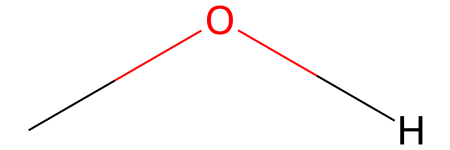

False

6

True

In [73]:
m=Chem.MolFromSmarts(Chem.MolToSmarts(Chem.MolFromSmiles('[H]Oc',sanitize=False)))
Chem.SanitizeMol(m)
m.UpdatePropertyCache(strict=False)
m
m.GetAtoms()[2].GetIsAromatic()
m.GetAtoms()[2].GetAtomicNum()
n=Chem.MolFromSmiles('[H]Oc',sanitize=False)
n.GetAtoms()[2].GetIsAromatic()

0

0

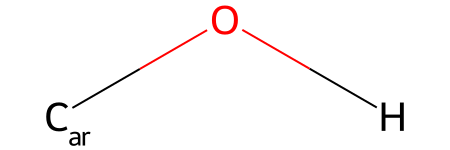

In [86]:
n.GetAtoms()[0].GetIdx()
m.GetAtoms()[0].GetIdx()
m.GetAtoms()[2].SetProp("_displayLabel","C<sub>ar</sub>")
# mol.GetAtomWithIdx(3).SetProp("_displayLabel","R<sub>1</sub>")
m

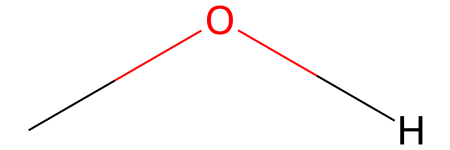

In [77]:
from rdkit.Chem import rdAbbreviations
abbrevs = rdAbbreviations.GetDefaultAbbreviations()
nm = rdAbbreviations.CondenseMolAbbreviations(m,abbrevs)
nm
abbrevs

In [47]:
Chem.Fragments.fr_Ar_OH(Chem.AddHs(Chem.MolFromSmiles('CC(=O)NC1=CC=C(C=C1)O')))

1

In [124]:
temp.loc[temp.FragmentSmiles=='COC(=O)N(C)C']

,SubstanceID,FragmentSmiles,count
153,28349593,COC(=O)N(C)C,1
385,13263142,COC(=O)N(C)C,1
452,19189832,COC(=O)N(C)C,1
515,21333123,COC(=O)N(C)C,1
791,9808753,COC(=O)N(C)C,1
...,...,...,...
50180454,14525820,COC(=O)N(C)C,1
50180664,7549637,COC(=O)N(C)C,1
50180740,10725846,COC(=O)N(C)C,1
50180793,10784965,COC(=O)N(C)C,1


## Functional group popularity

In [87]:
freq=temp[['SubstanceID','FragmentSmiles']].groupby(['FragmentSmiles'])['SubstanceID'].transform('count')
freqtable=temp[['FragmentSmiles']]
freqtable['Frequency']=freq
freqtable.drop_duplicates(inplace=True)
freqtable

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,FragmentSmiles,Frequency
0,CF,1034442
1,CBr,207543
2,cnc,2820013
3,cF,864157
4,[H]C1([H])OccO1,95034
...,...,...
50180462,[H]C(=C([H])C1=C([H])C([H])=C([H])C1=P(c)(c)c)...,1
50180467,[H]N(C)C(=O)O/N=C1/CN(C)C(C)(C)N1[H],1
50180509,[H]C([H])=C([S@@](c)=O)[S@](c)=O,1
50180824,C/C1=C(\[Sn](C)(C)C)[Si](C)(C)C2[Si](C)(C)/C([...,1


In [98]:
# freqtable.set_index('FragmentSmiles',inplace=True)
freqtable['Popularity'] = freqtable['Frequency'].div(freqtable['Frequency'].sum(axis=0), axis=0).multiply(100).round()

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


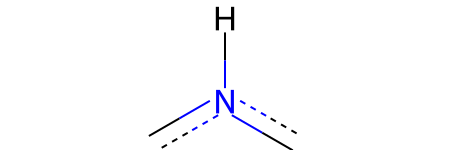

In [87]:
Chem.MolFromSmarts(Chem.MolToSmarts(Chem.MolFromSmiles('[H]n(c)c',sanitize=False)))

In [109]:
freqtable.sort_values(by=['Popularity'],ascending=False)[:50]
# freqtable.loc[freqtable.Frequency>=100].sort_values(by=['Popularity'],ascending=False)

,Frequency,Popularity
FragmentSmiles,,
cnc,2820013,6.0
cOC,2743793,5.0
COC(C)=O,1765485,4.0
[H]OC,2176832,4.0
cCl,1362946,3.0
COC,1693827,3.0
CN(C)C,993693,2.0
[H]Oc,756164,2.0
c=O,915341,2.0


In [103]:
freqtable.to_pickle('/home/aa2133/Impurity-Project/Reaxys_Data/fragfreq.pickle')

In [15]:
temp.reset_index(inplace=True)
temp.drop(columns=['index'],inplace=True)

In [21]:
temp.set_index('SubstanceID',inplace=True)

In [29]:
temp['Smiles']=substancedb.loc[substancedb.index.isin(temp.index)]['Smiles']
temp['>1 Compound']=substancedb.loc[substancedb.index.isin(temp.index)]['>1 Compound']

In [33]:
temp.dtypes

FragmentSmiles     string
count               Int64
Smiles             string
>1 Compound       boolean
dtype: object

In [38]:
temp.reset_index(inplace=True)

In [32]:
temp = temp.convert_dtypes()

In [56]:
temp.memory_usage(deep=True)

Index                    128
SubstanceID        401449520
FragmentSmiles    3308625317
count              451630710
Smiles            5967059055
>1 Compound        100362380
dtype: int64

In [40]:
temp.to_sql("FragmentDB1",db,if_exists="replace")

In [41]:
cursor.execute('''CREATE INDEX Idx6 ON FragmentDB1(FragmentSmiles);''')
cursor.execute('''CREATE INDEX Idx7 ON FragmentDB1(SubstanceID);''')

In [54]:
pd.read_sql_query('''SELECT SubstanceID,Smiles,">1 Compound" from FragmentDB1 Where FragmentSmiles="cnc";''',db)
# pd.read_sql_query('''SELECT * from FragmentDB1 Where FragmentSmiles="[H]N(C)C(=O)OC";''',db)

,SubstanceID,Smiles,>1 Compound
0,27615522,Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F,0
1,9019791,CCCCOc1ccc(-c2nc(-c3ccc(Cl)cc3)[nH]c2-c2ccncc2...,0
2,11185773,Cc1ccccc1CCCCCCC(=O)c1ncc(-c2ccccn2)o1,0
3,6156831,CCOC(=O)c1c(-c2cccc([N+](=O)[O-])c2)cc(-c2cccc...,0
4,11095222,CC(C)[Si](Cc1cc(-c2ccccc2)nc2ccc(Cl)cc12)(C(C)...,0
...,...,...,...
2820008,15730941,CCOP(=O)(COCCCONc1nc(NC=O)nc(Cl)c1NC=O)OCC,0
2820009,18091249,Cc1ccncc1.O=C([O-])C(Cl)(Cl)Cl.[Mn+2],1
2820010,24073116,COc1cc(C)nc(N=CN(C)C)n1,0
2820011,30477344,Cn1ccc2ccc(B(O)O)nc21,0


In [52]:
# cursor.execute('''EXPLAIN QUERY PLAN SELECT FragmentDB1.SubstanceID,FragmentDB1.FragmentSmiles,FragmentDB1.count,SubstanceDB.Smiles,SubstanceDB.">1 Compound" from FragmentDB1
#                     INNER JOIN SubstanceDB ON FragmentDB1.SubstanceID=SubstanceDB.SubstanceID WHERE FragmentDB1.FragmentSmiles="CF";''')

cursor.execute('''EXPLAIN QUERY PLAN SELECT SubstanceID,Smiles,">1 Compound" from FragmentDB1 Where FragmentSmiles="CF";''')

In [53]:
print(cursor.fetchall())

[(3, 0, 0, 'SEARCH TABLE FragmentDB1 USING INDEX Idx6 (FragmentSmiles=?)')]


## Reaction database modification

In [3]:
import pandas as pd

In [ ]:
rxndb=pd.read_sql_query('''SELECT ReactionID,NumRefs,ReactantID,ProductID,NumSteps,ReagentID,Temperature,Pressure,ResidenceTime,SolventID,CatalystID,ReactionType from ReactionDB''',db)

In [ ]:
rxndb['NumRefs']=rxndb['NumRefs'].apply(lambda x:int(x))
rxndb['ReactantID']=rxndb['ReactantID'].apply(lambda x:list(map(int,x.split(','))) if x else [])
rxndb['ProductID']=rxndb['ProductID'].apply(lambda x:list(map(int,x.split(','))) if x else [])
rxndb['NumSteps']=rxndb['NumSteps'].apply(lambda x:list(map(int,x.split(','))) if x else [])
rxndb['ReagentID']=rxndb['ReagentID'].apply(lambda x:list(map(int,x.split(','))) if x else [])
rxndb['SolventID']=rxndb['SolventID'].apply(lambda x:list(map(int,x.split(','))) if x else [])
rxndb['CatalystID']=rxndb['CatalystID'].apply(lambda x:list(map(int,x.split(','))) if x else [])

In [ ]:
def parsetemp(row):
    temp=row['Temperature']
    if temp:
        tempsplit=temp.strip().split(',')
        tempfinal=[]
        for elem in tempsplit:
            elem=elem.strip()
            if elem[0]=='-':
                templocal=elem[1:].split('-',1)
                templocal[0]='-'+templocal[0]
                tempfinal+=templocal
            else:
                tempfinal+=elem.split('-',1)
    else:
        tempfinal=[]
    return [float(elem) for elem in tempfinal]
def parsepressure(row):
    pressure=row['Pressure']
    errors=[]
    if pressure:
        try:
            pp=list(map(float,re.split(',|-',pressure)))
            return True
        except Exception:
            return False

In [ ]:
rxndbdis=mpd.DataFrame(rxndb)
tempcol=rxndbdis.apply(parsetemp,axis=1,result_type='reduce')
errors=rxndbdis.apply(parsepressure,axis=1,result_type='reduce')


In [ ]:
tempcol=pd.DataFrame(data=tempcol.values,index=tempcol.index)
rxndb['Temperature']=tempcol
rxndb['Pressure']=rxndb['Pressure'].apply(lambda x:re.split(',|-',x) if x else [])
rxndb['ResidenceTime']=rxndb['ResidenceTime'].apply(lambda x:re.split(',|-',x) if x else [])

In [ ]:
errors[errors.values==False].index

In [ ]:
rxndb.set_index(['ReactionID'],inplace=True)

In [8]:
pd.to_pickle(rxndb,'/home/aa2133/Impurity-Project/Reaxys_Data/ReactionDB.pickle')

In [4]:
rxndb=pd.read_pickle('/home/aa2133/Impurity-Project/Reaxys_Data/ReactionDB.pickle')

In [6]:
rxndb
rxndb.rename(columns={'ResidenceTime': 'ReactionTime'}, inplace=True)

## Substance database modification

In [ ]:
substancedb=pd.read_sql_query('''SELECT SubstanceID,Smiles,">1 Compound" from SubstanceDB''',db)
substancedb.dtypes
substancedb['>1 Compound']=substancedb['>1 Compound'].apply(lambda x:True if x=='1' else False)
substancedb.set_index(['SubstanceID'],inplace=True)
pd.to_pickle(substancedb,'/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceSmiles.pickle')

In [14]:
substancedb.loc[substancedb.Smiles=='Error']

,Smiles,MolFileAddress,Error,>1 Compound
SubstanceID,,,,
17039903,Error,/home/projects/graph/data/batch_6500000/17039903,Valence error,Error
27714712,Error,/home/projects/graph/data/batch_6500000/27714712,Valence error,Error
17632674,Error,/home/projects/graph/data/batch_6500000/17632674,Valence error,Error
16957119,Error,/home/projects/graph/data/batch_6500000/16957119,Valence error,Error
17509438,Error,/home/projects/graph/data/batch_6500000/17509438,Valence error,Error
...,...,...,...,...
17016447,Error,/home/projects/graph/data/batch_12600000/17016447,Valence error,Error
6619603,Error,/home/projects/graph/data/batch_12600000/6619603,Valence error,Error
14242245,Error,/home/projects/graph/data/batch_12600000/14242245,Valence error,Error


In [ ]:
conds=pd.read_sql_query('''SELECT ReactionID,CatalystID from ReactionDB''',db)
rxnids=pd.read_sql_query('''SELECT ReactionID,ReactantID from ReactionDB''',db)
rgtids=pd.read_sql_query('''SELECT ReactionID,ReagentID from ReactionDB''',db)
substanceids=pd.read_sql_query('''SELECT SubstanceID from SubstanceDB''',db)
unresolvedids=pd.read_sql_query('''SELECT SubstanceID from SubstanceDB Where Error!="No"''',db)

In [ ]:
freqtable=copy.deepcopy(substanceids)
rxnlist=','.join(rxnids.loc[rxnids.ReactantID.astype(bool)].ReactantID)
rgtlist=','.join(rgtids.loc[rgtids.ReagentID.astype(bool)].ReagentID)
catlist=','.join(conds.loc[conds.CatalystID.astype(bool)].CatalystID)
freqtable=freqtable.merge(pd.DataFrame(data=Counter([int(ID) for ID in rxnlist.split(',')]).most_common(),columns=['SubstanceID','RctFreq']),on=['SubstanceID'],how='outer')
freqtable=freqtable.merge(pd.DataFrame(data=Counter([int(ID) for ID in rgtlist.split(',')]).most_common(),columns=['SubstanceID','RgtFreq']),on=['SubstanceID'],how='outer')
freqtable=freqtable.merge(pd.DataFrame(data=Counter([int(ID) for ID in catlist.split(',')]).most_common(),columns=['SubstanceID','CatFreq']),on=['SubstanceID'],how='outer')

freqtable['RctFreq']=freqtable['RctFreq'].fillna(0)
freqtable['RgtFreq']=freqtable['RgtFreq'].fillna(0)
freqtable['CatFreq']=freqtable['CatFreq'].fillna(0)
# bb=pd.DataFrame([('a',2),('b',6)],columns=['lol','lol2'])
# bb
# cc=pd.DataFrame([('a',6),('c',7)],columns=['lol','lol3'])
# bb=bb.merge(cc,on=['lol'],how='left')
# bb['lol3']=bb['lol3'].fillna(0)
# bb

In [ ]:
freqtable.loc[freqtable.SubstanceID==1722526]

In [ ]:
freqtable['PCat']=freqtable['CatFreq'].div(freqtable[['RgtFreq','CatFreq']].sum(axis=1),axis=0).round(2)
freqtable['PCat']=freqtable['PCat'].fillna(0)

In [ ]:
pd.to_pickle(freqtable,'/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceFreq.pickle')

In [ ]:
PotCatList=list(freqtable.loc[freqtable.PCat>0.05].SubstanceID)
writepickle(PotCatList,'/home/aa2133/Impurity-Project/Reaxys_Data/','PotCatList')

In [ ]:
unresolvedids=set(unresolvedids.SubstanceID).union(set(freqtable.SubstanceID)-set(substanceids.SubstanceID))
writepickle(unresolvedids,'/home/aa2133/Impurity-Project/Reaxys_Data/','UnresolvedIDs')

## Sandbox

In [ ]:
getCarrierFrags0('COc1ccc2cccc(CC#N)c2c1',resFormat='smiles')

In [ ]:
dd.utils.is_dataframe_like(pd.DataFrame({'FragmentSmiles':[['asdasds']],'FragmentSmarts':[['asdasd']]}))

In [ ]:
if CarrierFragmentDB.index.name or CarrierFragmentDB.index.names:
    CarrierFragmentDB.reset_index(inplace=True)

In [ ]:
gk=pd.DataFrame(['BOO',None,'Do'])
gk
gk.dropna(inplace=True)
gk

In [ ]:
CarrierFragmentDB.loc[CarrierFragmentDB['SubstanceID']==4502]

In [ ]:
'>1 Compound' not in CarrierFragmentDB.columns

In [ ]:
CarrierFragmentDBDask=dd.from_pandas(CarrierFragmentDB,npartitions=181)
CarrierFragmentDBDask=client.persist(CarrierFragmentDBDask)

In [ ]:
type(CarrierFragmentDBDask)

In [ ]:
CarrierFragmentDB.columns[CarrierFragmentDB.columns.str.contains('ragment')]

In [ ]:
mixturecol=buildfragdb(fdb=CarrierFragmentDB,dfdb=CarrierFragmentDBDask,mixtures=True).compute()

In [ ]:
mixturecol

In [ ]:
mixturedf=pd.DataFrame(mixturecol)
CarrierFragmentDB=CarrierFragmentDB.join(mixturedf)

In [ ]:
CarrierFragmentDB.loc[CarrierFragmentDB['>1 Compound']==True]

In [ ]:
CarrierFragmentDB2=CarrierFragmentDB[:100].groupby(['SubstanceID','Smiles']).agg({'FragmentSmiles': lambda x: x.tolist(),'FragmentSmarts': lambda x: x.tolist(),'>1 Compound': lambda x: x.tolist()}) 

In [ ]:
type(CarrierFragmentDB2['FragmentSmiles'])

In [ ]:
CarrierFragmentDB.dtypes

In [ ]:
CarrierFragmentDB3.loc[925]['Smiles']

In [ ]:
CarrierFragmentDBDask.loc[:1000000]

In [ ]:
len(CarrierFragmentDB[:100].SubstanceID.unique())

In [ ]:
fdb=CarrierFragmentDB.loc[CarrierFragmentDB['>1 Compound']==True]

In [ ]:
fdbdask=dd.from_pandas(fdb,npartitions=16)

In [ ]:
fdbdask

In [ ]:
fdbdask=client.persist(fdbdask)

In [ ]:
CarrierFragmentDB3=fdbdask.groupby(['Smiles']).agg([list]).compute() 

In [ ]:
CarrierFragmentDB3=CarrierFragmentDB3.drop('list',axis=1,level=1)

In [ ]:
writepickle(CarrierFragmentDB3,'/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBmixtures_reduced(n=6)')

In [ ]:
CarrierFragmentDB3=openpickle('/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBmixtures_reduced(n=6).pickle')

In [ ]:
CarrierFragmentDB3

In [ ]:
ty=CarrierFragmentDB3[:2].apply(getMixturefrags,natoms=6,axis=1)

In [ ]:
ty

In [ ]:
CarrierFragmentDB3Dask=dd.from_pandas(CarrierFragmentDB3,npartitions=16)

In [ ]:
CarrierFragmentDB3Dask=client.persist(CarrierFragmentDB3Dask)

In [ ]:
CarrierFragmentDB3Dask.loc[CarrierFragmentDB3Dask['Smiles']=='B#N.N.[LiH].[LiH].[LiH]'].compute()['Smiles']

In [ ]:
CarrierFragmentDBDask.loc[CarrierFragmentDBDask['Smiles']=='B#N.N.[LiH].[LiH].[LiH]'].compute()['Smiles']

Getting mixture smarts

In [ ]:
mixturesmarts2=CarrierFragmentDB3Dask.loc[:2].map_partitions(getMixturefragspartition,natoms=6,meta=('FragmentSmarts','O')).compute()

In [ ]:
mixturesmarts=CarrierFragmentDB3Dask.map_partitions(getMixturefragspartition,natoms=6,meta=('FragmentSmarts','O')).compute()

In [ ]:
mixturesmarts=openpickle('/home/aa2133/Impurity-Project/Reaxys_Data/mixturesmarts.pickle')

In [ ]:
writepickle(mixturesmarts,'/home/aa2133/Impurity-Project/Reaxys_Data/mixturesmarts')

In [ ]:
mixturesmarts[1249046]

In [ ]:
mixturesmartsdf=pd.DataFrame(mixturesmarts)

In [ ]:
CarrierFragmentDB3['FragmentSmarts']=mixturesmartsdf['FragmentSmarts']

In [ ]:
CarrierFragmentDB4=CarrierFragmentDB3.explode('FragmentSmarts')

In [ ]:
CarrierFragmentDB4[['Smiles','FragmentSmarts']]

In [ ]:
CarrierFragmentDB4Dask=dd.from_pandas(CarrierFragmentDB4,npartitions=64)
CarrierFragmentDB4Dask=client.persist(CarrierFragmentDB4Dask)

In [ ]:
mixturefragsmiles=CarrierFragmentDB4Dask.map_partitions(getsmilespartition,meta=('FragmentSmiles','O')).compute()

In [ ]:
mixturefragsmiles

In [ ]:
CarrierFragmentDB4['FragmentSmiles']=pd.DataFrame(mixturefragsmiles)['FragmentSmiles']

In [ ]:
CarrierFragmentDB4.loc[CarrierFragmentDB4['Smiles']=='B#N.N.[LiH].[LiH].[LiH]']

In [ ]:
CarrierFragmentDB3Dask.loc[1249046].compute()['FragmentSmarts']['list'].values[0]

The final dataframe does have errors. Whilst errors converting molfile to smiles had been indentified and removed earlier, there are further errors as the conversion of molfile to smiles, whilst successful, may not be correct. These are all the entries where this is the case. Furthermore we can see where Reaxys has stored substances with the same smiles string but different substance IDs (The complexity of the substance cannot be translated to a valid smiles string. There are valence errors).

In [ ]:
CarrierFragmentDB4=explode(CarrierFragmentDB3[CarrierFragmentDB3.FragmentSmarts=='Error'],lst_cols=['SubstanceID','FragmentSmiles','>1 Compound'])

In [ ]:
CarrierFragmentDB4

In [ ]:
templist=CarrierFragmentDB3[CarrierFragmentDB3.FragmentSmarts=='Error'].SubstanceID.str.len()

In [ ]:
templist[templist.values>1]

In [ ]:
CarrierFragmentDB3[CarrierFragmentDB3.FragmentSmarts=='Error'].loc[51293].Smiles

In [ ]:
CarrierFragmentDB.loc[CarrierFragmentDB['Smiles']=='C1CCOC1.C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)(C)C.[Li+]']

In [ ]:
Chem.MolFromSmiles('C[Si](C)(C)[GeH2-]([Si](C)(C)C)[Si](C)(C)C')

In [ ]:
CarrierFragmentDB5=CarrierFragmentDB3[~CarrierFragmentDB3.Smiles.isin(CarrierFragmentDB4.Smiles)]

In [ ]:
CarrierFragmentDB6=explode(CarrierFragmentDB5,lst_cols=['SubstanceID','FragmentSmiles'])#'FragmentSmarts','>1 Compound'])

In [ ]:
CarrierFragmentDB3.loc[26211]

In [ ]:
CarrierFragmentDB.loc[CarrierFragmentDB['SubstanceID']==16800164]

In [ ]:
Chem.MolFromSmiles('Br[GeH2-](Br)Br.[Br-].[H][N+]([H])([H])[H]')

In [ ]:
CarrierFragmentDB.loc[CarrierFragmentDB['Smiles']=='B#N.N.[LiH].[LiH].[LiH]']

In [ ]:
testdb2=CarrierFragmentDB4.loc[CarrierFragmentDB4['Smiles']=='c1ccncc1.c1nc[nH]n1']

In [ ]:
testdb=CarrierFragmentDB.loc[CarrierFragmentDB['Smiles']=='c1ccncc1.c1nc[nH]n1']

In [ ]:
testdb2=testdb2.explode('SubstanceID')

In [ ]:
def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, df[lst_cols[0]].str.len())
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]

In [ ]:
testdb2

In [ ]:
testdb3=CarrierFragmentDB3.loc[CarrierFragmentDB3['Smiles']=='c1ccncc1.c1nc[nH]n1']

In [ ]:
explode(testdb3,lst_cols=['SubstanceID','FragmentSmiles','FragmentSmarts','>1 Compound'])

The below exposes some errors in the carrier frags function. The way RDKit treats smiles and smarts is not consistent at all, and fragments are even worse.

In [ ]:
Chem.MolFromSmiles('c1ccncc1.c1nc[nH]n1')
Chem.MolFromSmarts('[#6]:[#6](:[#7]:[#6](:[#6])-[H])-[H]')

In [ ]:
Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]')
Chem.MolFromSmiles('[H]C1:N:N:C([H]):N:1')

In [ ]:
getCarrierFrags('c1nc[nH]n1',6)
Chem.MolToSmiles(Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]'))
moltest=Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]')
Chem.SanitizeMol(moltest)
moltest.UpdatePropertyCache(strict=False)
Chem.MolToSmiles(moltest,allHsExplicit=False)
Chem.MolToSmiles(Chem.MolFromSmiles('[H]C1:N:N:C([H]):N:1'))

In [ ]:
Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]')
Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H]')

In [ ]:
Chem.MolToSmiles(Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H]'))

In [ ]:
Chem.MolFromSmiles('[H]C1:N:C([H]):N([H]):N:1')

In [ ]:
Chem.MolFromSmiles('c1ccncc1.c1nc[nH]n1')
Chem.MolFromSmiles('[H]C(:C):N:C([H]):C')
Chem.MolFromSmiles('[H]C1:N:N:C([H]):N:1')
Chem.MolFromSmiles('[H]C1:N:C([H]):N([H]):N:1')
Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H]'),allHsExplicit=True))
Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7](:[#7]:1)-[H])-[H])-[H]')

In [ ]:
Chem.MolToSmarts(Chem.MolFromSmarts('[#6]1(:[#7]:[#6](:[#7]:[#7]:1)-[H])-[H]'))

In [ ]:
Chem.MolToSmarts(Chem.MolFromSmiles('c1nc[nH]n1'))

In [ ]:
getCarrierFrags('c1nc[nH]n1',0,resFormat='smarts')

In [ ]:
Chem.MolFromSmarts('[#7]:[#7]')

In [ ]:
Chem.MolFromSmiles('[H]c1nc([H])n([H])n1')

In [ ]:
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

In [ ]:
testmol=Chem.MolFromSmiles('c1nc[nH]n1')
Chem.SanitizeMol(testmol)
testmol.UpdatePropertyCache(strict=False)
Chem.AddHs(testmol)
mol_with_atom_index(testmol)


In [ ]:
IFG(testmol)
testmol.GetAtomWithIdx(1)

In [ ]:
testdb2.set_index(['SubstanceID'],inplace=True)

In [ ]:
testdb.set_index('SubstanceID',inplace=True)

In [ ]:
testdb2.reset_index(inplace=True)

In [ ]:
pd.concat([testdb,testdb2])

In [ ]:
pd.concat([testdb,testdb2]).drop([16832508],level=1)

In [ ]:
CarrierFragmentDB4.index.unique()

In [ ]:
CarrierFragmentDB4.reset_index(inplace=True)

In [ ]:
CarrierFragmentDB

In [ ]:
CarrierFragmentDB4

In [ ]:
CarrierFragmentDBDask.loc[CarrierFragmentDBDask['SubstanceID']==31713109].compute()

In [ ]:
Chem.MolFromSmiles('*(c1ccccc1)c1ccccc1.N.N.[1*].[1*]')

In [ ]:
CarrierFragmentDB3.loc[1239046]

In [ ]:
CarrierFragmentDB.rename(columns={'CarrierFragmentSmiles':'FragmentSmiles','CarrierFragmentSmarts':'FragmentSmarts'},inplace=True)

In [ ]:
CarrierFragmentDBDask=CarrierFragmentDBDask.rename(columns={'CarrierFragmentSmiles':'FragmentSmiles','CarrierFragmentSmarts':'FragmentSmarts'})

In [ ]:
CarrierFragmentDBDask=client.persist(CarrierFragmentDBDask)

In [ ]:
CarrierFragmentDBDask

In [ ]:
res

In [ ]:
getCarrierFrags('Cl',6)

In [ ]:
getCarrierFrags('Brc1ccc2ncccc2c1',6)

In [ ]:
mol2=Chem.MolFromSmarts('[#17]')
Chem.SanitizeMol(mol2)
mol2.UpdatePropertyCache(strict=False)
Chem.MolToSmiles(mol2)
mol2.GetAtoms()[0].GetTotalNumHs()
Chem.MolToSmiles(Chem.MolFromSmiles(Chem.MolToSmiles(Chem.rdmolops.AddHs(mol2))))

In [ ]:
Chem.MolToSmiles(Chem.rdmolops.AddHs(Chem.MolFromSmiles('Brc1ccc2ncccc2c1')))

In [ ]:
# -- directories for Reaxys data
# allrxtidsdir='/home/zg268/py2projects/reaction_1/AllRxtIDs.dat'
# This file contains reactant IDs in Reaxys
allrxtidsdir = '/home/aa2133/Impurity-Project/Reaxys_Data/AllRxtIDs.dat'
# rxnSource='/home/projects/graph/11step_network_774355/zg_good_data_noDupRXID2.dat'
# This file contains the reaction network
rxnSource = '/home/aa2133/Impurity-Project/Reaxys_Data/zg_good_data_noDupRXID2.dat'

# This is a directory containing all mol files
molfilesource = '/home/projects/graph/data/'

# Dask

In [ ]:
from dask.distributed import Client, LocalCluster

In [ ]:
cluster=LocalCluster(n_workers=16,threads_per_worker=2,scheduler_port=42117) # dashboard_address=':8786
client = Client(cluster) #'127.0.0.1:8786' is default scheduler cluster

In [ ]:
client = Client('tcp://127.0.0.1:42117') #Use when scheduler already initiated

In [ ]:
client

In [ ]:
client.restart()

In [ ]:
cluster.close()
client.close()

# Cleaning Data

Below, the existing substance database is loaded as a pandas dataframe (pickle file) and processed(imputing missing values, defining column data types). Note that this takes up several gigabytes of space in memory but is nearly 10 times faster at retrieving indexed data (however, when doing intensive write/modifying operations on the entire database or non-indexed data slowdows will be expected due to inability to parallelize). For optimizing pandas, check https://engineering.upside.com/a-beginners-guide-to-optimizing-pandas-code-for-speed-c09ef2c6a4d6. Otherwise use pandas documentation: https://pandas.pydata.org/pandas-docs/stable/index.html

In [ ]:
substancedb = openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceDB.pickle")

In [ ]:
substancedb

The error column has NaN values as there is no error in processing the molfile. Therefore, imputation is needed (filling in missing values) 

In [ ]:
substancedb['Error'].fillna('No', inplace=True)
substancedb['Smiles'].fillna('Error', inplace=True)
substancedb.Error.unique()

Some pandas functions are depicted below to test speed of retrieval

In [ ]:
substancedb.loc[6138726]

substancedb.loc[substancedb['Smiles'] == 'COc1ccc(CCl)cc1OCc1ccc(C(F)(F)F)cc1']

In [ ]:
substancedb = substancedb.astype(
    {'MolFileAddress': 'str', 'Smiles': 'str', 'Error': 'str'})

In [ ]:
substancedb.dtypes

In [ ]:
substancedb.MolFileAddress.isnull().values.any()
substancedb.Smiles.isnull().values.any()
substancedb.Error.isnull().values.any()

The below indicates all entries where molfiles are unable to be processed. Around 1,281,117 compounds are not processable by RDKit, of which 1,281,041 is due to valence error and 76 are due to kekulization errors (related to lack of specification of hydrogens on rings). Most of these are massive compounds containing in excess of 40 carbons and 80 hydrogens.

In [ ]:
substancedb[substancedb['Error'] != 'No'].count()
substancedb[substancedb['Error'] == 'Valence error'].count()

In [ ]:
substancedb[(substancedb['Error'] != 'Valence error')
            & (substancedb['Error'] != 'No')]

In [ ]:
substancedb

Next, the goal is to identify mixtures or reaxys compounds that contain multiple substances (eg. salts). This is useful in the future as retrieving carrier fragments will entail splitting of the smiles string.

In [ ]:
substancedbdask = dd.from_pandas(substancedb, npartitions=16)
substancedbdask = client.persist(substancedbdask)

In [ ]:
mixturecol=substancedbdask.map_partitions(findMixturespartition,meta=('>1 Compound','boolean')).compute()
substancedb=joindf(pd.DataFrame(mixturecol),substancedb)
substancedb

In [ ]:
substancedb.reset_index(inplace=True)
substancedb.set_index(['Smiles','SubstanceID'],inplace=True)

In [ ]:
writepickle(substancedb, '/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceDB')

# Running fragment detection

## Building dask dataframe from cleaned substance database

The cells below build a dask dataframe with 16 partitions for faster parallel computation. It does not take up much memory in the server as a result, but is slower at reading/fetching indexed data. The final file is written to parquet (This has been deprecated as it takes too much memory. It is more advisable to generate a dask dataframe from pandas)

In [ ]:
substancedbdask = dd.from_pandas(substancedb, npartitions=16)

In [ ]:
substancedbdask = client.persist(substancedbdask)

In [ ]:
# substancedbdask.to_parquet(
#     "/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceDBDask")

## Loading dataframe and testing

In [ ]:
# substancedbdask = dd.read_parquet(
#     "/home/aa2133/Impurity-Project/Reaxys_Data/SubstanceDBDask")

In [ ]:
substancedbdask.info()

In [ ]:
substancedbdask.get_partition(2)
substancedbdask.memory_usage_per_partition().compute()

In [ ]:
substancedbdask.loc[2632386].compute()

substancedbdask.loc[substancedbdask['Smiles']
                    == 'Nc1cc(F)c(N2CC(F)C2)c(F)c1'].compute()

In [ ]:
substancedbdask.loc[2632386].compute()

In [ ]:
g = substancedbdask.loc[2632386, 'Smiles'].compute()[2632386]
g

In [ ]:
f = substancedb.loc[2632386, 'Smiles']
f

Now, the question remains whether it is best to build another column row by row or build a dataframe from an entire column. https://towardsdatascience.com/apply-function-to-pandas-dataframe-rows-76df74165ee4 has more details. Building an entire column, and appending this to the dataframe is better and has been implemented.

## Creating dask dataframe to house fragment data

Creating a new dataframe to house information on fragments. This is a subset of the substance database containing only substance IDs, Smiles and mixture identification where molfiles CAN be processed. The index is reset (as indexing is the same across all partitions ie. 1 to 1000000 for partition 1, 1 to 1000000 for partition2 and so on), and a dask dataframe (substancedbdask2) is generated. Totally 14.8 million compounds out of the original 16 million compounds can be processed this way.

In [ ]:
fdbm=substancedb.reset_index()[['SubstanceID', 'Smiles','>1 Compound']]
fdbm=fdbm[fdbm.Smiles!='Error']
substancedbdask2=dd.from_pandas(fdbm,npartitions=16)
substancedbdask2=client.persist(substancedbdask2)

In [ ]:
substancedbdask2['SubstanceID'].count().compute()

## Simple solution (Pandas)

The bottom section served to highlight how inefficient it is using pandas (single core)

In [ ]:
testset = substancedbdask2.head(100000)

In [ ]:
testset

In [ ]:
applycol=testset.apply(getfrags,natoms=0,axis=1)

2.17 seconds per every 100 rows translates to {{2.17*(16000000/100)/3600}} hours

In [ ]:
applycol

## Simple solution (parallel)

This employs dask. However, it is slower for smaller datasets. The get carrier frags function is applied to each partition in the modified substance database using all 16 cores for carrier fragments (n=6). Subsequently, fragment smiles are calculated by processing the fragment smarts. The reason for this is that there are many smarts representations of a fragment structure but only one canonical smiles, so filtering the database by canonical smiles can capture more analogue compounds. This workflow is first tested on a test set of 100 compounds to ensure everything work smoothly and then tested on the entire dataset. The results are stored in pickle files on the server

### Test set

In [ ]:
dasktestset=dd.from_pandas(substancedbdask2.loc[:100].compute(),npartitions=16)
dasktestset=client.persist(dasktestset)

In [ ]:
dasktestset.loc[dasktestset['>1 Compound']==True].compute()

In [ ]:
applycolp2=dasktestset.map_partitions(getfragpartition,natoms=6,meta=('FragmentSmarts','O')).compute()
dasktestset=client.persist(dd.from_pandas(joindf(pd.DataFrame(applycolp2),substancedbdask2.loc[:100].compute()),npartitions=16)) 

In [ ]:
applycolp3=dasktestset.map_partitions(getsmilespartition,meta=('FragmentSmiles','O')).compute()

In [ ]:
finaldb=joindf(pd.DataFrame(applycolp3),joindf(pd.DataFrame(applycolp2),substancedbdask2.loc[:100].compute()))

In [ ]:
finaldb2=joindf(pd.DataFrame(applycolp2),substancedbdask2.loc[:100].compute())

In [ ]:
finaldb2=finaldb2.explode('FragmentSmarts')

In [ ]:
finaldb2.loc[finaldb2['FragmentSmarts']=='Error']

In [ ]:
pd.DataFrame(applycolp3).explode('FragmentSmiles')

In [ ]:
finaldb.loc[1].FragmentSmarts
finaldb.loc[1].FragmentSmiles

In [ ]:
finaldb.loc[1]

Something to take note is that the fragment smarts should be used in substructure searches instead of fragment smiles, as it is often invalid/cannot generate a valid molecule due to valence errors.

In [ ]:
mol_with_atom_index(Chem.MolFromSmarts('[#6]-[#6](:[#7]:[#6](:[#6]):[#6]):[#6]'))
Chem.MolFromSmiles('C:C(C):N:C(:C):C')

In [ ]:
testmol=Chem.MolFromSmiles('Cc1cc(-c2nc3cc(F)ccc3c3cc4c(cc23)OCO4)ccc1F')
testmol=Chem.AddHs(testmol)
patt=Chem.MolFromSmarts('[#6]-[#6](:[#7]:[#6](:[#6]):[#6]):[#6]')

In [ ]:
testmol.GetSubstructMatches(patt)

In [ ]:
testmol

In [ ]:
dasktestset.loc[0].compute()['Smiles'].values[0]

### Real dataset

In [ ]:
carrierfragsmarts=substancedbdask2.map_partitions(getfragpartition,natoms=6,meta=('FragmentSmarts','O')).compute()
carrierfragsmartsdf=pd.DataFrame(carrierfragsmarts)
writepickle(carrierfragsmartsdf,"/home/aa2133/Impurity-Project/Reaxys_Data/fragsmarts(n=6)")

substancedbdask2=client.persist(dd.from_pandas(joindf(carrierfragsmartsdf,fdbm),npartitions=16))
carrierfragsmiles=substancedbdask2.map_partitions(getsmilespartition,meta=('FragmentSmiles','O')).compute()
carrierfragsmilesdf=pd.DataFrame(carrierfragsmiles)
writepickle(carrierfragsmilesdf,"/home/aa2133/Impurity-Project/Reaxys_Data/fragsmiles(n=6)")

In [ ]:
carrierfragsmartsdf=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/fragsmarts(n=6).pickle")
carrierfragsmilesdf=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/fragsmiles(n=6).pickle")

We now have columns for fragment smarts and fragment smiles of each compound in the database, taking roughly 1.5 hours using 16 cores on the server. This is almost 100 times faster than just using a single core, which would take almost 3-4 days.

In [ ]:
carrierfragsmartsdf
carrierfragsmilesdf

In [ ]:
substancedbdask2.memory_usage(deep=True).compute()

Restarting workers after computation will free up memory

In [ ]:
client.restart()

# Assembling final dataframe

In [ ]:
fdbm

Now that we have all the columns we intend to add, we can merge the fragment smarts and fragment smiles columns (exploded so each column is a new fragment), and merge the combined dataframe with the master database (fdbm). The index is set to a multiindex, containing fragment smiles and substance ID.  Keep in mind that if generating a dask dataframe from this, the index needs to be reset as dask is not compatible with multiindex. The final file is writted to disk. A test is done on 20 rows and then replicated for the entire dataset. It is hard to reshuffle data in the final database due to its size (68 million rows) or implode it back to a list form. There may be a better way to handle such large datasets (SQL for instance, but on trying this, the disk space is massive due to metadata >18 gb).

In [ ]:
fdbmlite=fdbm.loc[:20]

In [ ]:
fdbmlite
cfsmartslite=carrierfragsmartsdf.loc[:20]
cfsmileslite=carrierfragsmilesdf.loc[:20]

In [ ]:
cfsmarts=cfsmartslite.explode('FragmentSmarts')
cfsmarts['FragmentSmiles']=cfsmileslite.explode('FragmentSmiles')
joindf(cfsmarts,fdbmlite)

In [ ]:
carrierfragsmartsdf=carrierfragsmartsdf.explode('FragmentSmarts')
carrierfragsmartsdf['FragmentSmiles']=carrierfragsmilesdf.explode('FragmentSmiles')

In [ ]:
carrierfragsmartsdf

In [ ]:
fdbm.drop('FragmentSmarts',axis=1,inplace=True) #Option (to clean dataframe if excess columns are already there)

In [ ]:
fdbm=joindf(carrierfragsmartsdf,fdbm)

In [ ]:
fdbm

In [ ]:
fdbm.index

In [ ]:
fdbm.set_index(['FragmentSmiles','SubstanceID'],inplace=True)

In [ ]:
writepickle(fdbm,'/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDB(n=6)')

The entire above workflow (Section 4) has been condensed into a function, `buildfragmentdb`in Section 1. Applying this function to generate the active fragment (n = 0) database

In [ ]:
buildfragdb(fdbm=testset,fragseries=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/cf_res.pickle"),pfdb=True,writepfdb="/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragment(n=6)DB")

In [ ]:
buildfragdb(fdb=ActiveFragmentDB,dfdb=True,writedfdb='/home/aa2133/Impurity-Project/Reaxys_Data/ActiveFragmentDBDask')

In [ ]:
buildfragdb(fdb=CarrierFragmentDB,dfdb=True,writedfdb='/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBDask(n=6)')

In [ ]:
buildfragdb(fdb=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/ActiveFragmentDB.pickle"),pfdb=True,writepfdb="/home/aa2133/Impurity-Project/Reaxys_Data/ActiveFragmentDB")

In [ ]:
buildfragdb(fdb=CarrierFragmentDB,writepfdb="/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDB(n=6)")

# Testing and cleaning

The main takeaways here are that the dask dataframe is faster on multiple tries after persisting than pandas version due to more cores able to search. Also, it is more amenable for intensive parallel computation that requires processing of each row. However, it is far more memory intensive, takes up more space (by a factor of 8 times in some cases) on disk and does not support multi-indexing. 

As the dask database is likely to be grouped by fragment it makes the most sense to apply it as an index (keeping in mind that creating a dask dataframe needs to be done by resetting the index or setting substance id as an index). *This is difficult, as the kernel keeps dying for some reason. For now, substance ID is kept as the index.*

For the pandas dataframe, multindexing by fragment and substance ID is most effective both in reducing disk space of the database, and speed of access. If the database can be loaded to memory, pandas is preferable (Takes roughly 1.5 minutes to load).

## Carrier Fragment Database (n=6)

### Dask dataframe

In [ ]:
CarrierFragmentDBDask=dd.read_parquet('/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBDask(n=6)')

In [ ]:
CarrierFragmentDB.set_index('SubstanceID',inplace=True)

In [ ]:
CarrierFragmentDBDask=dd.from_pandas(CarrierFragmentDB,npartitions=181)

# CarrierFragmentDBDask=CarrierFragmentDBDask.repartition(partition_size=100000000)

CarrierFragmentDBDask=client.persist(CarrierFragmentDBDask)

In [ ]:
CarrierFragmentDBDask.loc[CarrierFragmentDBDask['CarrierFragments']=='[#7](-[#6](:[#6]):[#6])(-[H])-[H]'].compute()

In [ ]:
CarrierFragmentDBDask.to_parquet('/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBDask(n=6)')

In [ ]:
CarrierFragmentDB2=openpickle('/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBDask(n=6).pickle')

In [ ]:
writepickle(CarrierFragmentDBDask,'/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDBDask(n=6)')

In [ ]:
demoset=CarrierFragmentDBDask.loc['[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]'].compute()

In [ ]:
demoset=CarrierFragmentDBDask.loc[CarrierFragmentDBDask['CarrierFragments']=='[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]'].compute()

In [ ]:
demoset['SubstanceID']

In [ ]:
Chem.MolFromSmiles(demoset.loc[11305,'Smiles'])

In [ ]:
CarrierFragmentDBDask2.loc['Error'].compute()

In [ ]:
CarrierFragmentDBDask.loc[CarrierFragmentDBDask['CarrierFragments']=='Error'].compute()

In [ ]:
CarrierFragmentDBDask.loc[71120:73000].compute()

In [ ]:
CarrierFragmentDBDask.known_divisions

### Pandas dataframe

In [ ]:
CarrierFragmentDB=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/CarrierFragmentDB(n=6).pickle")

In [ ]:
CarrierFragmentDB.reset_index(inplace=True)

In [ ]:
CarrierFragmentDBDask=CarrierFragmentDBDask.rename(columns={'CarrierFragments':'CarrierFragmentSmarts'})

In [ ]:
CarrierFragmentDBDask

For information on meta types see https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/. For how to use it on dask, see make_meta under dask dataframe API

In [ ]:
help(np.dtype)

In [ ]:
smiles=CarrierFragmentDBDask.map_partitions(getsmilespartition,meta=('CarrierFragmentSmiles','O')).compute()

In [ ]:
smilesdf=pd.DataFrame(smiles)

In [ ]:
CarrierFragmentDB=CarrierFragmentDB.join(smilesdf)

In [ ]:
CarrierFragmentDB.rename(columns={'CarrierFragments':'CarrierFragmentSmarts'},inplace=True)

In [ ]:
CarrierFragmentDB.set_index(['CarrierFragmentSmiles','SubstanceID'],inplace=True)

In [ ]:
CarrierFragmentDB.index

In [ ]:
CarrierFragmentDB.loc['Error']

.xs is used for multiindexed dataframes

In [ ]:
CarrierFragmentDB.xs('Error')

In [ ]:
test1=CarrierFragmentDB.xs('[#7](-[#6](:[#6]):[#6])(-[H])-[H]').index

In [ ]:
test2=CarrierFragmentDBDask.loc[CarrierFragmentDBDask['CarrierFragments']=='[#7](-[#6](:[#6]):[#6])(-[H])-[H]'].index.compute()

In [ ]:
CarrierFragmentDBDask.index.compute()

In [ ]:
# CarrierFragmentDB.xs(294913,level=1)
CarrierFragmentDB.xs(4502,level=1)

In [ ]:
Chem.MolFromSmiles('Nc1ccc2ncccc2c1N')

In [ ]:
CarrierFragmentDB.xs('[H]N([H])C(:C):C')

In [ ]:
CarrierFragmentDB.loc[CarrierFragmentDB['CarrierFragmentSmarts']=='[#7](-[#6](:[#6]):[#6])(-[H])-[H]']

In [ ]:
Chem.MolFromSmarts('[#7](-[#6](:[#6]):[#6])(-[H])-[H]')

In [ ]:
CarrierFragmentDB.xs('[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]')

In [ ]:
CarrierFragmentDB.xs(11305,level=1,drop_level=False)
CarrierFragmentDB.xs('[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]',drop_level=False)

In [ ]:
Chem.MolFromSmiles('Nc1ccc2[nH]cnc2c1')

### SQL Database

Very slow write speed (>15 mins for 65 million rows). Only benefit is compatibility outside python, and reading from disk due to memory constraints. It is interestingly quite fast (1 second), and at most half a minute. See https://pandas.pydata.org/pandas-docs/version/0.15.0/io.html#sql-queries. Obviously it cannot compare to in-memory pandas which when indexed properly takes less than a second. However, this could be useful in cases where memory is scarce or the database is far too large to load in memory. 

In [ ]:
import sqlite3
import os

In [ ]:
CarrierFragmentDB.reset_index(inplace=True)

In [ ]:
db2=sqlite3.connect("/home/aa2133/Impurity-Project/Reaxys_Data/SQL/Reaxys_Data.db")

In [ ]:
CarrierFragmentDB.set_index('CarrierFragments',inplace=True)

In [ ]:
CarrierFragmentDB.to_sql("CarrierFragment(n=6)",db,if_exists="replace")

In [ ]:
cursor = db2.cursor()
df = pd.read_sql_query('''select * from [CarrierFragment(n=6)]''', db2)

In [ ]:
df.info()

In [ ]:
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
for table_name in tables:
    table_name = table_name[0]

In [ ]:
cursor.execute('''CREATE INDEX CarrierFragments ON [CarrierFragment(n=6)] (CarrierFragments);''')

In [ ]:
pd.read_sql_query('''SELECT * from [CarrierFragment(n=6)] Where CarrierFragments="[#6]-[#6](=[#8])-[#8]-[#6](-[#6])=[#8]"''',db2)

In [ ]:
pd.read_sql_query('''SELECT * from [CarrierFragment(n=6)] Where Smiles="CC(=O)Nc1ccc(O)cc1"''',db2)

In [ ]:
pd.read_sql_query('''SELECT * from [CarrierFragment(n=6)] Where Smiles="CC(=O)OC(=O)c1ccc(C(=O)OC(C)=O)o1"''',db2)

In [ ]:
Chem.MolToSmiles(Chem.MolFromSmiles('CC(=O)NC1=CC=C(C=C1)O'))

In [ ]:
Chem.MolFromSmarts('[#6]-[#6](=[#8])-[#7](-[#6])-[H]')

In [ ]:
Chem.MolFromSmiles('CC(=O)Nc1ccc(O)cc1')

## Active Fragment Database (n=0)

### Dask dataframe

In [ ]:
ActiveFragmentDBDask=dd.read_parquet('/home/aa2133/Impurity-Project/Reaxys_Data/ActiveFragmentDBDask')
ActiveFragmentDBDask=client.persist(ActiveFragmentDBDask)

In [ ]:
ActiveFragmentDBDask.loc[ActiveFragmentDBDask['ActiveFragments']=='[#8]-[Si]'].compute()
ActiveFragmentDBDask.loc[ActiveFragmentDBDask['ActiveFragments']=='[Si]-[#8]'].compute()
ActiveFragmentDBDask.loc[ActiveFragmentDBDask['ActiveFragments']=='Error'].compute()

### Pandas dataframe

In [ ]:
ActiveFragmentDB=openpickle("/home/aa2133/Impurity-Project/Reaxys_Data/ActiveFragmentDB.pickle")

In [ ]:
ActiveFragmentDB

In [ ]:
ActiveFragmentDB.loc['[#8]-[Si]']
ActiveFragmentDB.loc['[Si]-[#8]']
ActiveFragmentDB.loc['Error']

As shown above, it is possible to group compounds and their smiles based on active fragment. Some records encountered errors (238). This is because of incorrect RDKit translation of molfile to smiles strings. Whilst the issue is resolved by reading smarts instead of smiles, the carrierfrags function will need to be adapted.

In [ ]:
errormol=Chem.MolFromMolFile(substancedb.loc[71120,'MolFileAddress'])
errormol
Chem.MolFromSmiles(Chem.MolToSmiles(errormol))
Chem.MolFromSmiles('C=Cc1cc(OC)c(OC)c2c1/c=c\\c1ccc(cc1)-o-c1c(c(C=C)cc(OC)c1OC)/c=c\\c1ccc(cc1)-o-2')

In [ ]:
deem=Chem.MolFromSmarts(Chem.MolToSmarts(errormol))
Chem.SanitizeMol(deem)
deem.UpdatePropertyCache(strict=False)
deem=Chem.rdmolops.AddHs(deem)
IFG(deem)

Two cells below check whether it is faster to load a mol from molfile, or generating it from smiles. The latter is slightly faster, but the former is useful in cases where the smiles is incorrect as is the case above.

In [ ]:
%%timeit -n 1 -r 1
Chem.MolFromMolFile(substancedb.loc[47408,'MolFileAddress'])

In [ ]:
%%timeit -n 1 -r 1
Chem.MolFromSmiles(substancedb.loc[47408,'Smiles'])

In [ ]:
Chem.MolToSmarts(errormol)

In [ ]:
len(ActiveFragmentDB.loc['[#8]-[Si]','Smiles'].values)

In [ ]:
ActiveFragmentDB.index.unique()

In [ ]:
ActiveFragmentDB.loc[ActiveFragmentDB['SubstanceID']==33195,'Smiles']

In [ ]:
Chem.MolFromSmiles('CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@H]2[C@H]1O[Si](C)(C)C')
getCarrierFrags('CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@H]2[C@H]1O[Si](C)(C)C',0)

In [ ]:
Chem.MolFromSmiles('C[Si]1(C)CCCO1')

In [ ]:
Chem.MolToSmiles(Chem.MolFromSmarts('[Si]-[#8]'))

In [ ]:
IFG(Chem.MolFromSmiles('C[Si]1(C)CCCO1'))
IFG(Chem.MolFromSmiles('CO[C@@H]1O[C@@H]2[C@H](O[Si](C)(C)C)C(=O)O[C@@H]2[C@H]1O[Si](C)(C)C'))

In [ ]:
getCarrierFrags('C[Si]1(C)CCCO1',0)

In [ ]:
ActiveFragmentDB.loc[1000001,'ActiveFragments']

In [ ]:
ActiveFragmentDB.loc[1000001,'Smiles']
ActiveFragmentDB.loc[1000001,'SubstanceID']

In [ ]:
getCarrierFrags(ActiveFragmentDB.loc[1000001,'Smiles'],0)

In [ ]:
getCarrierFrags(testset.loc[testset['SubstanceID']==28713377,'Smiles'][0],0)

In [ ]:
dfaf

In [ ]:
dfafdask=dd.from_pandas(dfaf,npartitions=16)

In [ ]:
dfafdask.loc[0,'ActiveFragments'].compute()

In [ ]:
testset.loc[0,'Smiles']

In [ ]:
substancedbdask.loc[substancedbdask['Smiles']=='COC(OC)C(=O)COC(C)=O'].compute()

In [ ]:
substancedb.loc[substancedb['Smiles']=='COC(OC)C(=O)COC(C)=O']

# Conclusion

Further results have been discussed/included in Preidct_Impurities.ipynb

In [ ]:
%whos

In [ ]:
substancedb

Finding an entry by Smiles and Reaxys ID

In [ ]:
substancedb.xs('CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2C(=O)[O-].[Li+]')
substancedb.xs('CC(C)(C)c1ccc2c(c1)c1cc(C(C)(C)C)ccc1n2C(=O)[O-].[Li+]').index[0]

Finding an entry by Reaxys ID and Smiles

In [ ]:
substancedb.xs(22727365,level=1)
substancedb.xs(22727365,level=1).index[0]